In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import requests
import datetime

In [2]:
pip install alpha_vantage

In [3]:
#pull out data
API_KEY = ''

symbol = 'SPY'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&outputsize=full'

response = requests.get(url)
data = response.json()

# Check if the data retrieval was successful
if 'Time Series (Daily)' in data:
    df = pd.DataFrame(data['Time Series (Daily)']).T
    df = df[['1. open', '2. high', '3. low', '4. close', '5. volume']]
    df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    print(df.head())
else:
    print("Error retrieving data")

                Open      High       Low     Close   Volume
1999-11-01  136.5000  137.0000  135.5625  135.5625  4006500
1999-11-02  135.9687  137.2500  134.5937  134.5937  6516900
1999-11-03  136.0000  136.3750  135.1250  135.5000  7222300
1999-11-04  136.7500  137.3593  135.7656  136.5312  7907500
1999-11-05  138.6250  139.1093  136.7812  137.8750  7431500


In [4]:
#plot data
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'],
                name='Candlestick Chart')])

fig.update_layout(title="SPY Stock Price",
                  xaxis_title="Date",
                  yaxis_title="Price",
                  template="plotly_dark")

fig.show()

In [5]:
#clean and add features
#added the necessary features like moving averages and the Relative Strength Index (RSI)
# Convert columns to numeric values
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
df['High'] = pd.to_numeric(df['High'], errors='coerce')
df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

# Add Moving Averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# Add RSI (14-day)
def compute_RSI(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI'] = compute_RSI(df['Close'])

# Drop rows with NaN values from moving averages and RSI
df = df.dropna()

print(df.head())

                Open      High       Low     Close   Volume        MA50  \
2000-08-15  149.3437  149.8125  148.5625  149.1562  5564600  147.010286   
2000-08-16  149.3125  149.9375  147.8437  148.6250  5191600  147.053412   
2000-08-17  148.6875  150.4375  148.3437  150.1875  5652200  147.107476   
2000-08-18  150.3750  150.3750  149.2187  149.6875  4626400  147.163102   
2000-08-21  150.0312  150.7187  149.4062  150.5000  2380600  147.241228   

                 MA200        RSI  
2000-08-15  143.682091  60.914486  
2000-08-16  143.747403  60.788310  
2000-08-17  143.825372  80.327943  
2000-08-18  143.896310  75.845411  
2000-08-21  143.966154  75.728155  


In [6]:
#prepare data for LSTM model
# Ensure the necessary libraries are imported
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scaling the data to the range (0, 1) for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close', 'Volume', 'MA50', 'MA200', 'RSI']].values)

# Create sequences for LSTM model
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])  # Create sequences from past 'seq_length' days
        y.append(data[i, 0])  # Predicting the 'Close' price (index 0)
    return np.array(x), np.array(y)

# Split data into training and test sets (80% for training, 20% for testing)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define the sequence length (number of previous days to consider for prediction)
seq_length = 60  # 60 days of history to predict the next day

# Prepare training and test sets
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape the data to fit the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Check the shape of the prepared data
print(X_train.shape, X_test.shape)

(4995, 60, 5) (1204, 60, 5)


The model will have two LSTM layers and a dense layer for output

In [7]:
#build LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Output the predicted closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0045
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 4.5989e-04
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 3.6560e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 3.2134e-04
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 2.5582e-04
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 3.0915e-04
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 2.9396e-04
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 2.2059e-04
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 1.8830e-04
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 1.8823e-04


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


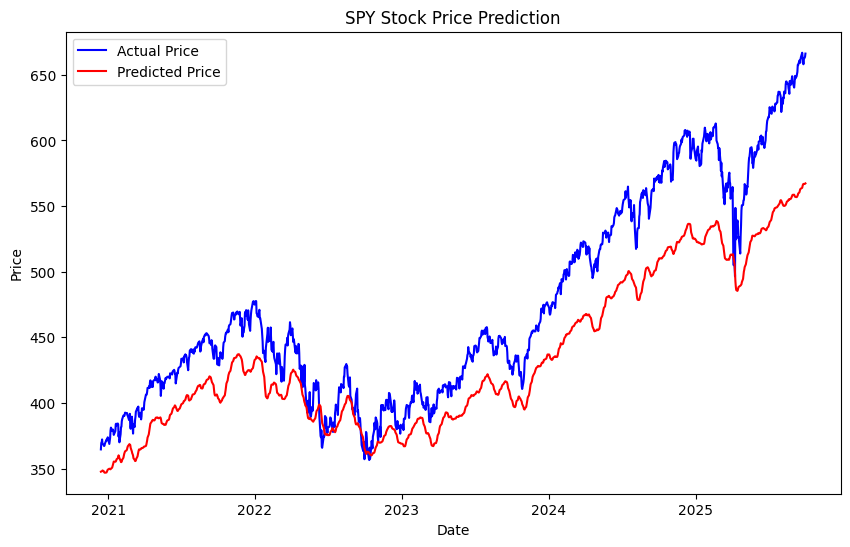

In [8]:
#make predictions
# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to get the actual values
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 4))), axis=1))[:, 0]

# Get the actual values from the test set
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1))[:, 0]

# Plot the actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(df.index[train_size + seq_length:], y_test_actual, color='blue', label='Actual Price')
plt.plot(df.index[train_size + seq_length:], predictions, color='red', label='Predicted Price')
plt.title('SPY Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
import plotly.graph_objs as go

# Create the figure
fig = go.Figure()

# Get the dates for the test set predictions
actual_dates = df.index[train_size + seq_length:]

# Actual prices
fig.add_trace(go.Scatter(x=actual_dates, y=y_test_actual, mode='lines', name='Actual Price'))

# Predicted prices
fig.add_trace(go.Scatter(x=actual_dates, y=predictions, mode='lines', name='Predicted Price'))

# Add title and labels
fig.update_layout(
    title='SPY Stock Price Prediction',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_dark'
)

fig.show()

In [11]:
#evaluate the model
#calculating the evaluation metrics (such as RMSE) to assess the performance of your model.
from sklearn.metrics import mean_squared_error
import math

# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 44.4621687548422


In [12]:
# Compile the model with accuracy as a metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

# Evaluate on the testing data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Testing Loss: {test_loss}")
print(f"Testing Accuracy: {test_accuracy}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 1.7480e-04 - loss: 0.3005
Training Loss: 0.39743223786354065
Training Accuracy: 0.0002002002001972869
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 4.2593e-05 - loss: 0.6647
Testing Loss: 0.6002858281135559
Testing Accuracy: 0.000830564764328301


In [13]:
#Confusion Matrix and Classification Report
# Ensure y_test is binary (1 for higher, 0 for lower)
y_test_binary = y_test.astype(int)

# Convert continuous probabilities to binary predictions (1 if higher, 0 if lower)
predictions_binary = (predictions > 0.5).astype(int)  # 1 if probability > 0.5, else 0

# Now compute the confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

# Get the confusion matrix
cm = confusion_matrix(y_test_binary, predictions_binary)
print("Confusion Matrix:")
print(cm)

# Get the classification report (precision, recall, f1-score)
report = classification_report(y_test_binary, predictions_binary)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[   0 1203]
 [   0    1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1203
           1       0.00      1.00      0.00         1

    accuracy                           0.00      1204
   macro avg       0.00      0.50      0.00      1204
weighted avg       0.00      0.00      0.00      1204



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 2.4256e-04 - loss: 0.3982 - val_accuracy: 8.3056e-04 - val_loss: 0.5856
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 5.7546e-05 - loss: 0.3984 - val_accuracy: 8.3056e-04 - val_loss: 0.5858
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 2.6701e-05 - loss: 0.3955 - val_accuracy: 8.3056e-04 - val_loss: 0.5913
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 2.9045e-04 - loss: 0.4044 - val_accuracy: 8.3056e-04 - val_loss: 0.5920
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 1.8408e-04 - loss: 0.3977 - val_accuracy: 8.3056e-04 - val_loss: 0.5913
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 8.6235e-05 - loss: 0.3984 - val_accuracy: 8.3056e-04 - val_loss: 0.5880
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 2.3020e-04 - loss: 0.3976 - val_accuracy: 8.3056e-04 - val_loss: 0.5902
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━

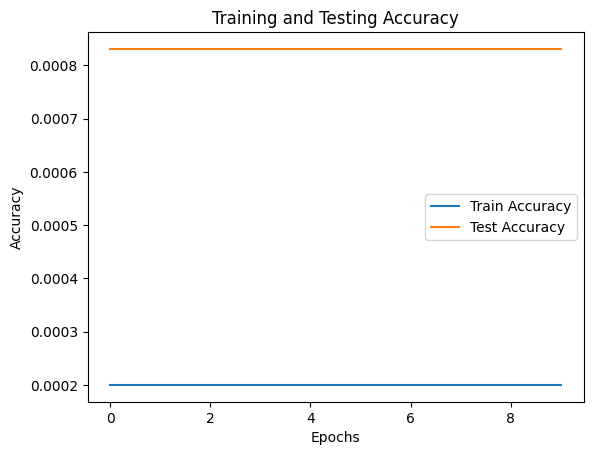

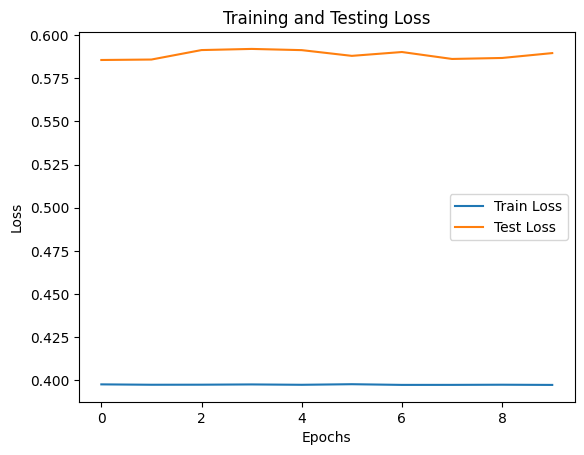

In [14]:
# Plot training and validation accuracy/loss curves
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Build the LSTM model
model = Sequential()

# Define the input layer (use the shape of the training data)
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Input layer

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))  # Output the predicted closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0047
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 5.3579e-04
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 3.9800e-04
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 3.2542e-04
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 3.1411e-04
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 2.6262e-04
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 2.3431e-04
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 2.1166e-04
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 2.2607e-04
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 2.0494e-04


In [16]:
#hyperparameter tuning
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [17]:
#adding more features
#changing LSTM structure so Bidirectional LSTMs for capturing patterns in both directions of time
df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
df['BB_up'] = df['Close'].rolling(window=20).mean() + 2*df['Close'].rolling(window=20).std()
df['BB_down'] = df['Close'].rolling(window=20).mean() - 2*df['Close'].rolling(window=20).std()

In [18]:
#updated model evaluation
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_actual, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 38.88523336435325


In [19]:
# Save the model ]
model.save('spy_stock_model.keras')

In [20]:
from tensorflow.keras.models import load_model

# Load the model without the optimizer's state
model = load_model('spy_stock_model.keras', compile=False)

# Compile the model again with the same optimizer settings
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
#rebuilding optimizer
from tensorflow.keras.optimizers import Adam

# Load the model without the optimizer's state
model = load_model('spy_stock_model.keras', compile=False)

# Compile with your desired optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [22]:
#using same parameters and extracting optimizer
from tensorflow.keras.optimizers import RMSprop

# Load the model with compile=False to avoid the optimizer state issue
model = load_model('spy_stock_model.keras', compile=False)

# Recompile with the same optimizer used when training the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mean_squared_error')

In [23]:
#makinging predictions with loaded model
# Example: Predict the next day's price using the last 60 days of data from the test set
# Get the last 60 days' data (for real-time prediction, this would come from a live data source)
input_data = test_data[-60:].reshape((1, 60, 5))  # Reshape to fit the model's input shape

# Make prediction
prediction = model.predict(input_data)

# Inverse transform to get the actual predicted closing price
predicted_price = scaler.inverse_transform(np.concatenate((prediction, np.zeros((prediction.shape[0], 4))), axis=1))[:, 0]

print(f"Predicted closing price for the next day: {predicted_price[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
Predicted closing price for the next day: 63.72476995020173


In [24]:
#evaluating model perfomance
# Calculate RMSE (Root Mean Squared Error) on the test set
from sklearn.metrics import mean_squared_error
import math

# Inverse transform the actual values in the test set
y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1))[:, 0]

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# You can also calculate other metrics like MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_actual, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 44.4621687548422
Mean Absolute Error (MAE): 38.88523336435325


In [25]:
# 1) Candlestick chart
fig.write_image("artifacts/candlestick.png")  # requires kaleido installed

# 2) Actual vs Predicted (Matplotlib)
plt.savefig("artifacts/actual_vs_predicted.png")

# 3) Actual vs Predicted (Plotly)
fig.write_image("artifacts/actual_vs_predicted_plotly.png")

# 4) Training curves
plt.savefig("artifacts/training_accuracy.png")   # for accuracy
plt.savefig("artifacts/training_loss.png")       # for loss

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [26]:
pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 kB 3.8 MB/s eta 0:00:00


In [27]:
# ==== SETUP ====
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

os.makedirs("artifacts", exist_ok=True)

# If you're using Plotly figures elsewhere and want to save them:
# !pip install -q kaleido

CLEAN SPLIT + SCALING (NO LEAKAGE)

In [28]:
# Assumes you already have a DataFrame `df` indexed by date with these columns:
feature_cols = ['Close', 'Volume', 'MA50', 'MA200', 'RSI']  # keep order fixed
target_col = 'Close'
seq_length = 60  # lookback window

# chronological split (80/20)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

# scale features using ONLY train
mm_scaler = MinMaxScaler()
mm_scaler.fit(train_df[feature_cols])

train_scaled = mm_scaler.transform(train_df[feature_cols])
test_scaled  = mm_scaler.transform(test_df[feature_cols])

def build_sequences(data_scaled, seq_len=60, target_idx=0):
    X, y = [], []
    for i in range(seq_len, data_scaled.shape[0]):
        X.append(data_scaled[i-seq_len:i, :])
        y.append(data_scaled[i, target_idx])        # next-step Close (scaled)
    return np.array(X), np.array(y).reshape(-1, 1)

X_train, y_train = build_sequences(train_scaled, seq_length, target_idx=feature_cols.index(target_col))
X_test,  y_test  = build_sequences(test_scaled,  seq_length, target_idx=feature_cols.index(target_col))

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# helper: invert-only-target (Close) from scaled predictions
def invert_close(pred_scaled, scaler, feature_count=5, close_idx=0):
    # pred_scaled shape: (n, 1)
    tmp = np.zeros((pred_scaled.shape[0], feature_count))
    tmp[:, close_idx] = pred_scaled[:, 0]
    return scaler.inverse_transform(tmp)[:, close_idx:close_idx+1]

Shapes: (4995, 60, 5) (4995, 1) (1204, 60, 5) (1204, 1)


REGRESSION BASELINE: NAÏVE

In [30]:
# Build the naïve prediction directly in original scale on the test slice
test_close = test_df[target_col].iloc[seq_length:].to_numpy().reshape(-1,1)   # y_true (original scale)
naive_pred = test_df[target_col].shift(1).iloc[seq_length:].to_numpy().reshape(-1,1)  # yesterday's close

rmse_naive = np.sqrt(mean_squared_error(test_close, naive_pred))
mae_naive  = mean_absolute_error(test_close, naive_pred)
print(f"Naïve baseline -> RMSE: {rmse_naive:.3f} | MAE: {mae_naive:.3f}")

Naïve baseline -> RMSE: 5.034 | MAE: 3.551


EVALUATE LSTM REGRESSOR

LSTM -> RMSE: 411.216 | MAE: 403.452


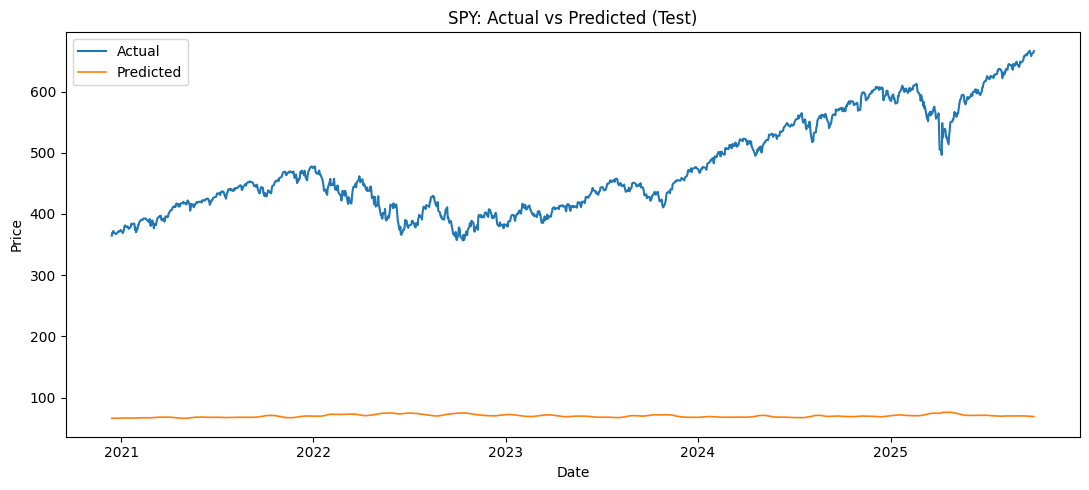

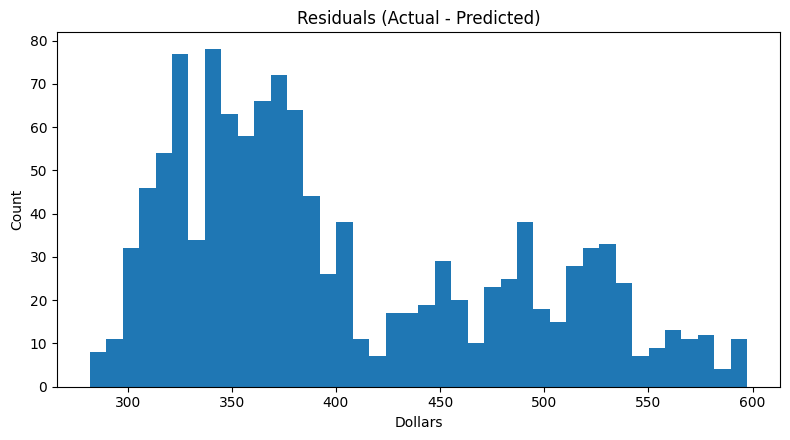

In [31]:
# Model should output scaled Close; invert to original scale
pred_test_scaled = model.predict(X_test, verbose=0)  # shape (n,1)
pred_test = invert_close(pred_test_scaled, mm_scaler, feature_count=len(feature_cols), close_idx=0)

y_test_orig = invert_close(y_test, mm_scaler, feature_count=len(feature_cols), close_idx=0)

rmse_lstm = np.sqrt(mean_squared_error(y_test_orig, pred_test))
mae_lstm  = mean_absolute_error(y_test_orig, pred_test)
print(f"LSTM -> RMSE: {rmse_lstm:.3f} | MAE: {mae_lstm:.3f}")

# ==== Actual vs Predicted (Matplotlib) ====
dates_test = test_df.index[seq_length:]  # align to y_test length
plt.figure(figsize=(11,5))
plt.plot(dates_test, y_test_orig, label='Actual', linewidth=1.5)
plt.plot(dates_test, pred_test, label='Predicted', linewidth=1.2)
plt.title('SPY: Actual vs Predicted (Test)')
plt.xlabel('Date'); plt.ylabel('Price'); plt.legend()
plt.tight_layout()
plt.savefig("artifacts/actual_vs_predicted.png", dpi=160)
plt.show()

# ==== Residuals plot ====
residuals = (y_test_orig - pred_test).ravel()
plt.figure(figsize=(8,4.5))
plt.hist(residuals, bins=40)
plt.title('Residuals (Actual - Predicted)')
plt.xlabel('Dollars'); plt.ylabel('Count')
plt.tight_layout()
plt.savefig("artifacts/residuals_hist.png", dpi=160)
plt.show()

CLASSIFICATION BASELINE: LOGISTIC REGRESSION

Logistic baseline -> ROC-AUC: 0.501
Confusion Matrix:
 [[340 238]
 [407 279]]
              precision    recall  f1-score   support

           0      0.455     0.588     0.513       578
           1      0.540     0.407     0.464       686

    accuracy                          0.490      1264
   macro avg      0.497     0.497     0.489      1264
weighted avg      0.501     0.490     0.486      1264



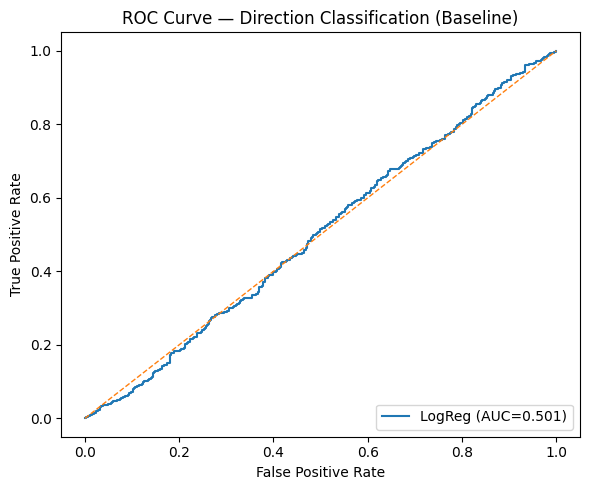

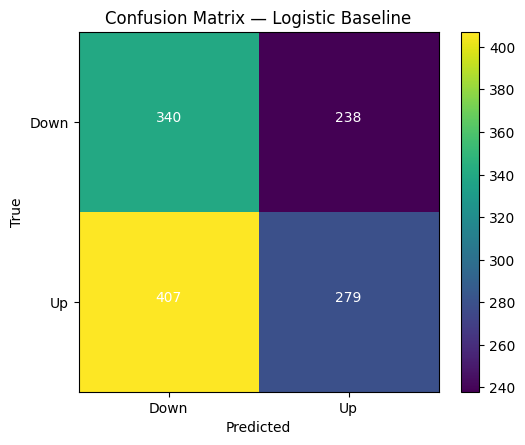

In [33]:
# Build labels: 1 if next-day Close > today Close
close = df['Close']
y_dir = (close.shift(-1) > close).astype(int)

# Simple features: daily return & RSI (you can add MA slopes, MACD, etc.)
feat = pd.DataFrame({
    'ret1': close.pct_change(),
    'rsi': df['RSI']
}, index=df.index).dropna()

# Align features and labels (drop last label due to shift(-1))
y_dir = y_dir.loc[feat.index]
y_dir = y_dir.iloc[:-1]
feat  = feat.iloc[:-1]

# Chronological split
split_idx_cls = int(len(feat) * 0.8)
Xtr, Xte = feat.iloc[:split_idx_cls].copy(), feat.iloc[split_idx_cls:].copy()
ytr, yte = y_dir.iloc[:split_idx_cls].copy(), y_dir.iloc[split_idx_cls:].copy()

# Scale features on train only
std = StandardScaler().fit(Xtr)
Xtr_s = std.transform(Xtr)
Xte_s = std.transform(Xte)

# Fit logistic regression
logit = LogisticRegression(max_iter=200, class_weight='balanced')
logit.fit(Xtr_s, ytr)

# Predict probs and labels
probs = logit.predict_proba(Xte_s)[:,1]
preds = (probs >= 0.5).astype(int)

# Metrics
auc  = roc_auc_score(yte, probs)
cm   = confusion_matrix(yte, preds)
print(f"Logistic baseline -> ROC-AUC: {auc:.3f}")
print("Confusion Matrix:\n", cm)
print(classification_report(yte, preds, digits=3))

# ROC Curve (saved)
fpr, tpr, thr = roc_curve(yte, probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'LogReg (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Direction Classification (Baseline)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("artifacts/roc_curve.png", dpi=160)
plt.show()

# Confusion Matrix heatmap (saved)
plt.figure(figsize=(5.5,4.5))
import itertools
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix — Logistic Baseline')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Down','Up']); plt.yticks(tick_marks, ['Down','Up'])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True'); plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig("artifacts/confusion_matrix.png", dpi=160)
plt.show()

In [35]:
print("## 📊 Results\n")
print("### Regression")
print(f"- LSTM: RMSE = `{rmse_lstm:.3f}` | MAE = `{mae_lstm:.3f}`")
print(f"- Naïve: RMSE = `{rmse_naive:.3f}` | MAE = `{mae_naive:.3f}`")
print("\nArtifacts: `artifacts/actual_vs_predicted.png`, `artifacts/residuals_hist.png`")

print("\n### Classification (Baseline)")
print(f"- Logistic Regression: ROC-AUC = `{auc:.3f}`")
print("Artifacts: `artifacts/roc_curve.png`, `artifacts/confusion_matrix.png`")


## 📊 Results

### Regression
- LSTM: RMSE = `411.216` | MAE = `403.452`
- Naïve: RMSE = `5.034` | MAE = `3.551`

Artifacts: `artifacts/actual_vs_predicted.png`, `artifacts/residuals_hist.png`

### Classification (Baseline)
- Logistic Regression: ROC-AUC = `0.501`
Artifacts: `artifacts/roc_curve.png`, `artifacts/confusion_matrix.png`
